# Fuel Efficiency Assignment
## Adapted from TensorFlow Tutorials
Using the [Boston Housing jupyter notebook](Boston_Housing_Example.ipynb) as an example follow the prompts below to build a neural network to predict vehicle fuel efficiency.

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/tmp/ipykernel_542838/1226147920.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [4]:
# Import the necessary libraries
import keras_tuner as kt
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
# import torch
# import torch.nn as nn

2025-01-23 14:10:09.459788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737609009.473910  542838 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737609009.477658  542838 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 14:10:09.493184: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Download the dataset
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [6]:
# Add labels to columns and view dataset
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [7]:
# Vehicle origin needs to be encoded to factors.  
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [8]:
# Separate target to not use in imputation
target = dataset.pop('MPG')

# Split the dataset into training , validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((278, 9), (60, 9), (60, 9))

I performed the train-val-test split up here as not to call any fit methods on the validation or testing set.

In [9]:
# Remove missing data
missing_idx = X_train[X_train.isnull().any(axis=1)].index
X_train.loc[missing_idx]

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
336,4,140.0,NaN,2905.0,14.3,80,1.0,0.0,0.0
374,4,151.0,NaN,3035.0,20.5,82,1.0,0.0,0.0
32,4,98.0,NaN,2046.0,19.0,71,1.0,0.0,0.0
354,4,100.0,NaN,2320.0,15.8,81,0.0,1.0,0.0
330,4,85.0,NaN,1835.0,17.3,80,0.0,1.0,0.0


5 missing values in the training set

In [10]:
# Impute missing data
imputer = KNNImputer()
X_train = pd.DataFrame(imputer.fit_transform(X_train), index=X_train.index, columns=imputer.feature_names_in_)
X_val = pd.DataFrame(imputer.transform(X_val), columns=imputer.feature_names_in_)
X_test = pd.DataFrame(imputer.transform(X_test), columns=imputer.feature_names_in_)
X_train.loc[missing_idx]

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
336,4.0,140.0,108.8,2905.0,14.3,80.0,1.0,0.0,0.0
374,4.0,151.0,88.2,3035.0,20.5,82.0,1.0,0.0,0.0
32,4.0,98.0,62.4,2046.0,19.0,71.0,1.0,0.0,0.0
354,4.0,100.0,80.8,2320.0,15.8,81.0,0.0,1.0,0.0
330,4.0,85.0,62.6,1835.0,17.3,80.0,0.0,1.0,0.0


Here are the same 5 values after imputation. Nothing looks out of the ordinary to me.

In [11]:
X_val.isnull().sum()

Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
USA             0
Europe          0
Japan           0
dtype: int64

In [12]:
X_test.isnull().sum()

Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
USA             0
Europe          0
Japan           0
dtype: int64

No missing values in the validation set or test set.

In [13]:
# Normalize the data by subtracting the mean from each feature and divide by one standard deviation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1,1))
y_val = target_scaler.transform(y_val.values.reshape(-1,1))
y_test = target_scaler.transform(y_test.values.reshape(-1,1))

# Load data into tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1737609011.886303  542838 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10192 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:10:00.0, compute capability: 8.9


Puting the datasets into TensorFlow Datasets sped up the training considerably.

In [ ]:
# Build a sequential neural network model.  Start with backend.clear_session()
# Think about what activation function you will use, the input shape, number of nodes, and output shape and activation
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(9,)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Compile the model.  Use 'rmsprop' optimizer.  Think about what loss function and metrics you need to use for a
# regression problem and add it below.
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 449 (1.75 KB)

 Trainable params: 449 (1.75 KB)

 Non-trainable params: 0 (0.00 B)

Relu is the standard activation it seems and I chose 2 small layers as this is a simple dataset and I don't want overfitting.

In [15]:
# Fit the model.  Use 1000 epochs.  Add a validation split to your model.  Set verbose = 0.
history = model.fit(train_dataset, validation_data=val_dataset, epochs=1000, verbose=0)

I0000 00:00:1737609013.084376  542946 service.cc:148] XLA service 0x7eabfc01eec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737609013.084398  542946 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-01-23 14:10:13.099322: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737609013.145741  542946 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1737609013.519468  542946 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [16]:
# Use this bit of code to view the History output.
hist = pd.DataFrame(history.history)
display(hist)

,loss,mae,val_loss,val_mae
0,1.280476,0.920479,0.844965,0.741214
1,0.967221,0.792413,0.647273,0.639526
2,0.788939,0.705980,0.526277,0.568984
3,0.665924,0.642200,0.447048,0.520974
4,0.576033,0.591043,0.392253,0.488651
...,...,...,...,...
995,0.032032,0.123522,0.113853,0.266447
996,0.033705,0.125460,0.131190,0.287281
997,0.033529,0.127889,0.124091,0.278784
998,0.033985,0.128507,0.113869,0.265971


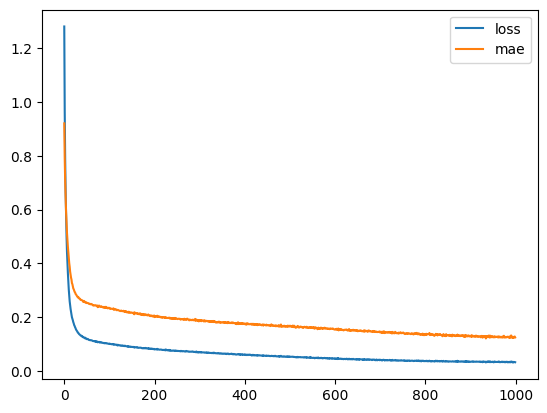

In [17]:
#Get the loss and MAE vs epochs
plt.plot(hist['loss'], label='loss')
plt.plot(hist['mae'], label='mae')
plt.legend()
plt.show()

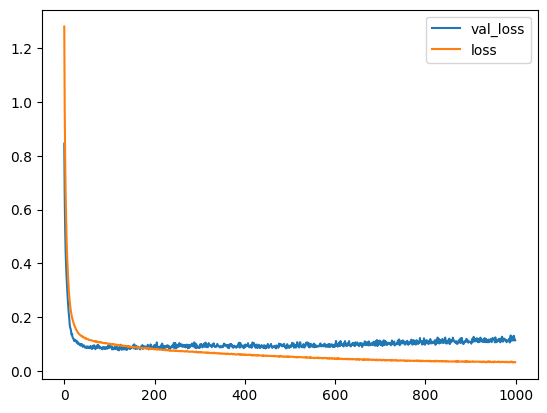

In [18]:
# Use the Boston Housing example to plot the validation and training loss vs epochs
plt.plot(hist['val_loss'], label='val_loss')
plt.plot(hist['loss'], label='loss')
plt.legend()
plt.show()

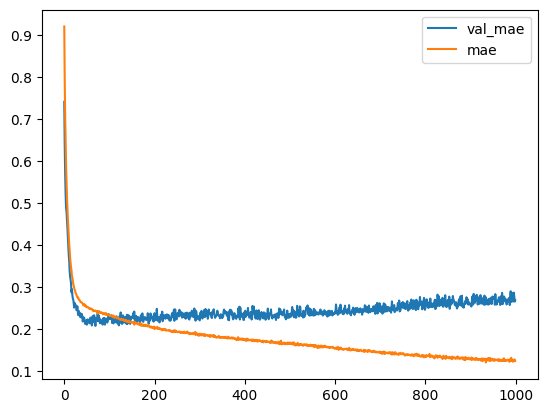

In [19]:
# Use the Boston Housing example to plot the validation and training mean absolute error vs epochs
plt.plot(hist['val_mae'], label='val_mae')
plt.plot(hist['mae'], label='mae')
plt.legend()
plt.show()

It looks like the model is overfitting after about 20 epochs.

In [20]:
# Evaluate the model on the test data and print the results
mse, mae = model.evaluate(test_dataset)
print(f'Mean Squared Error: {(mse * target_scaler.scale_[0]**2):.2f}')
print(f'Mean Absolute Error: {mae * target_scaler.scale_[0]:.2f}')

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1517 - mae: 0.2689

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1656 - mae: 0.2854
Mean Squared Error: 10.77
Mean Absolute Error: 2.32


Build a new model and try to get the  accuracy as high as you can. Things to try: more hidden layers and hidden units, activation types, epochs, batch size, and validation_split. Try as many models as you like.  

Be sure to clear the session each time: `backend.clear_session()`. Copy your best model at the end of the notebook.

In [21]:
tf.keras.backend.clear_session()

def model_builder(hp):
    n_hidden = hp.Int('n_hidden', min_value=2, max_value=4)
    n_units = hp.Int('n_units', min_value=8, max_value=128, step=2, sampling='log')
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    dropout = hp.Float('dropout', min_value=0.0, max_value=0.5)
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.learning_rate = learning_rate
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(9,)))
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_units, activation='relu', kernel_initializer='he_normal'))
        model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

<div class="alert alert-block alert-warning">
<b>Warning:</b> Running the next cell will create a folder in your working directory and save results of the hyperparameter search
</div>

In [22]:
tuner = kt.BayesianOptimization(model_builder, objective='val_loss', max_trials=100, project_name='auto_mpg')
tuner.search(train_dataset, epochs=1000, validation_data=val_dataset, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=10, restore_best_weights=True)])

Reloading Tuner from ./auto_mpg/tuner0.json


In [23]:
best_trial = tuner.oracle.get_best_trials()[0]
best_trial.summary()

Trial 052 summary
Hyperparameters:
n_hidden: 2
n_units: 128
learning_rate: 0.01
dropout: 0.0
optimizer: adam
Score: 0.06562497466802597


In [24]:
best_trial.best_step

25

In [25]:
best_model = tuner.get_best_models()[0]
mse, mae = best_model.evaluate(test_dataset)
print(f'Mean Squared Error: {(mse * target_scaler.scale_[0]**2):.2f}')
print(f'Mean Absolute Error: {mae * target_scaler.scale_[0]:.2f}')

/home/chandon/miniconda3/envs/tf-test/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 702ms/step - loss: 0.0787 - mae: 0.2139
Mean Squared Error: 5.13
Mean Absolute Error: 1.73


Those are better metrics than the first model.

In [26]:
eval_df = pd.DataFrame(scaler.inverse_transform(X_test), columns=scaler.feature_names_in_)
eval_df['Actual_MPG'] = target_scaler.inverse_transform(y_test)
eval_df['Predicted_MPG'] = target_scaler.inverse_transform(best_model.predict(X_test))
eval_df

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan,Actual_MPG,Predicted_MPG
0,4.0,120.0,97.0,2506.0,14.5,72.0,0.0,0.0,1.0,23.0,21.745138
1,4.0,121.0,115.0,2671.0,13.5,75.0,0.0,1.0,0.0,25.0,21.520363
2,8.0,318.0,150.0,4237.0,14.5,73.0,1.0,0.0,0.0,14.0,13.417418
3,8.0,400.0,175.0,4464.0,11.5,71.0,1.0,0.0,0.0,14.0,12.597260
4,4.0,98.0,90.0,2265.0,15.5,73.0,0.0,1.0,0.0,26.0,24.369585
5,6.0,198.0,95.0,2904.0,16.0,73.0,1.0,0.0,0.0,23.0,19.360546
6,6.0,258.0,110.0,2962.0,13.5,71.0,1.0,0.0,0.0,18.0,19.068069
7,8.0,390.0,190.0,3850.0,8.5,70.0,1.0,0.0,0.0,15.0,13.826414
8,6.0,173.0,115.0,2700.0,12.9,79.0,1.0,0.0,0.0,26.8,25.442041
9,8.0,350.0,150.0,4699.0,14.5,74.0,1.0,0.0,0.0,13.0,13.170512


# Pytorch implementation

I was going to try using pytorch too and I got it running, and recreated the results, but when I tried to run the whole notebook I realized the pytorch package was interfering with the tensorflow package. It was something to do with CuDNN. Oh well. 